<a href="https://colab.research.google.com/github/akshitadixit/Retinopathy/blob/main/final_CNN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive
drive.mount("/content/gdrive")

import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,Conv2D,Dropout,Dense,Activation, MaxPooling2D, Flatten

import multiprocessing
from multiprocessing.pool import ThreadPool

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# path to the dataset directory

data_root = "/content/gdrive/My Drive/Colab Notebooks/dataset/"

In [3]:
#model = tf.keras.models.load_model(os.path.join(data_root, "saved_model/"))
train = pd.read_pickle(data_root+"train_gen.pkl")
validate = pd.read_pickle(data_root+"valid_gen.pkl")
test = pd.read_pickle(data_root+"test_gen.pkl")

In [19]:
# reading the saved data cz its dope XD

train = pd.read_pickle(data_root+"train.pkl")
test = pd.read_pickle(data_root+"test.pkl")

In [20]:
# shuffle and split data

train = shuffle(train)
train, validate = np.split(train, [int(.85*len(train))])

In [4]:
IMG_SIZE = 512

In [5]:
# Model parameters
BATCH_SIZE = 25
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-5
HEIGHT = 256
WIDTH = 256
CANAL = 3
N_CLASSES = 5
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [22]:
train_idg = ImageDataGenerator(rescale=1./255)#, horizontal_flip=True, vertical_flip=True, rotation_range=0.2, zoom_range=0.2)
test_idg = ImageDataGenerator(rescale=1./255)

train_generator = train_idg.flow_from_dataframe(dataframe=train,
                                                      directory=os.path.join(data_root,'train_images_pro/'),
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH))

valid_generator = train_idg.flow_from_dataframe(dataframe=validate,
                                                      directory=os.path.join(data_root,'train_images_pro/'),
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH))

test_generator = test_idg.flow_from_dataframe(dataframe=test,
                                                      directory=os.path.join(data_root,'test_images_pro/'),
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [27]:
import gc
gc.collect()

3045

In [8]:
model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
124/124 [==============================] - 42s 340ms/step - loss: 0.6422 - accuracy: 0.7583 - val_loss: 0.6331 - val_accuracy: 0.7600
Epoch 2/2
124/124 [==============================] - 43s 343ms/step - loss: 0.6100 - accuracy: 0.7668 - val_loss: 0.6019 - val_accuracy: 0.7527


In [13]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
model.save(os.path.join(data_root, "saved_model/"))

KeyboardInterrupt: ignored

In [14]:
import pickle
pkl_filename = data_root+"pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

TypeError: ignored

In [16]:
#os.mkdir(os.path.join(data_root, "saved_model/"))
#model.save(os.path.join(data_root, "saved_model/"))
train.to_pickle(data_root+"train_gen.pkl")
validate.to_pickle(data_root+"valid_gen.pkl")
test.to_pickle(data_root+"test_gen.pkl")

In [25]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
124/124 [==============================] - 46s 366ms/step - loss: 0.5713 - accuracy: 0.7868 - val_loss: 0.5972 - val_accuracy: 0.7745
Epoch 2/20
124/124 [==============================] - 45s 361ms/step - loss: 0.5235 - accuracy: 0.8102 - val_loss: 0.5811 - val_accuracy: 0.7709
Epoch 3/20
124/124 [==============================] - 44s 357ms/step - loss: 0.4843 - accuracy: 0.8270 - val_loss: 0.5575 - val_accuracy: 0.7782
Epoch 4/20
124/124 [==============================] - 42s 334ms/step - loss: 0.4350 - accuracy: 0.8461 - val_loss: 0.5843 - val_accuracy: 0.7709
Epoch 5/20
124/124 [==============================] - 38s 307ms/step - loss: 0.3899 - accuracy: 0.8669 - val_loss: 0.5939 - val_accuracy: 0.7745
Epoch 6/20
124/124 [==============================] - 38s 306ms/step - loss: 0.3317 - accuracy: 0.8905 - val_loss: 0.5758 - val_accuracy: 0.7891

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 7/20
124/124 [=============================

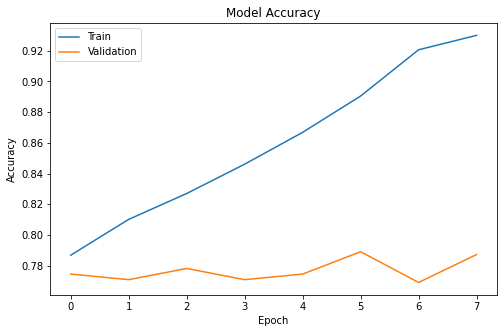

In [26]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0

In [28]:
keras.utils.plot_model(model)

AttributeError: ignored

# Trying Functional model